# PPL Example 1: Activity Choice (without Context)

In [22]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

In [23]:
def model(data=None):
    alpha = numpyro.sample('alpha', dist.Dirichlet(jnp.repeat(1, 4)))
    obs = numpyro.sample('obs', dist.MultinomialProbs(alpha), obs=data)

In [24]:
# cycling, picnic, climbing, movie = 20, 20, 20, 40
data = jnp.array([20, 20, 20, 40])

In [31]:
# Parameter estimation
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=1)
mcmc.run(random.PRNGKey(12345), data=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 2707.11it/s, 3 steps of size 8.28e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  alpha[0]      0.20      0.04      0.20      0.14      0.26   2178.23      1.00
  alpha[1]      0.20      0.04      0.20      0.13      0.26   1806.38      1.00
  alpha[2]      0.20      0.04      0.20      0.14      0.26   1678.05      1.00
  alpha[3]      0.39      0.05      0.39      0.32      0.47   1873.90      1.00

Number of divergences: 0


In [29]:
import arviz as az
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
# Prior distribution of the parameter theta

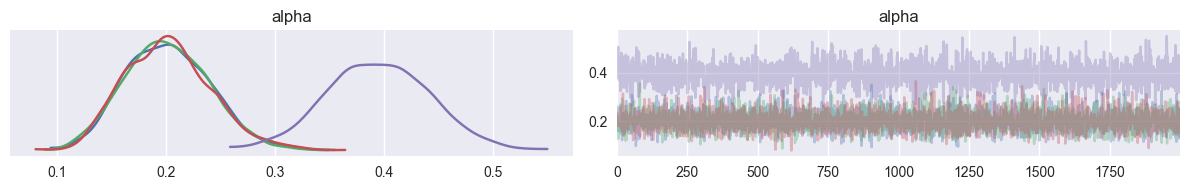

In [30]:
trace = az.from_numpyro(mcmc)
axes = az.plot_trace(trace)
plt.tight_layout()

plt.show()


In [27]:
predictive = Predictive(model, mcmc.get_samples(), return_sites=['obs'])
pred = predictive(random.PRNGKey(1))

def activity_name(activity_array: jnp.ndarray) -> str:
    idx = jnp.argmax(activity_array)
    return ["cycling", "picnic", "climbing", "movie"][idx]

for i in range(10):
    activity = activity_name(pred["obs"][i])
    print(f"Activity: {activity}")

Activity: climbing
Activity: climbing
Activity: cycling
Activity: movie
Activity: movie
Activity: climbing
Activity: movie
Activity: movie
Activity: movie
Activity: movie


# PPL Example 2 Activity Choice (with Context)

In [34]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

In [35]:
data = jnp.array([[0, 0, 15, 10],
                  [15, 5, 0, 5],
                  [0, 0, 5, 20],
                  [5, 15, 0, 5]])

mood = jnp.array([0, 0, 1, 1])
weather = jnp.array([0, 1, 0, 1])

In [51]:
def model(mood, weather, obs=None):
    lam = numpyro.sample("lam", dist.Exponential(rate=1.0)) 
    
    alpha_mood = numpyro.sample("alpha_mood", dist.Exponential(rate=lam).expand((2, 4)))
    alpha_weather = numpyro.sample("alpha_weather", dist.Exponential(rate=lam).expand((2, 4)))
    alpha_0 = jnp.repeat(1, 4)
    
    with numpyro.plate("context", 4):
        concentration = numpyro.deterministic("concentration", alpha_0 + alpha_mood[mood, :] + alpha_weather[weather, :])
        probs = numpyro.sample("probs", dist.Dirichlet(concentration=concentration))
        numpyro.sample("obs", dist.Multinomial(probs=probs), obs=obs)

In [55]:
# Parameter estimation
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, thinning=1)
mcmc.run(random.PRNGKey(12345), obs=data, mood=mood, weather=weather)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:01<00:00, 1732.45it/s, 15 steps of size 1.98e-01. acc. prob=0.93]



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_mood[0,0]      0.46      0.66      0.25      0.00      1.08    803.45      1.00
   alpha_mood[0,1]      0.33      0.40      0.20      0.00      0.75    949.30      1.01
   alpha_mood[0,2]      0.44      0.58      0.25      0.00      1.04    913.44      1.00
   alpha_mood[0,3]      0.65      0.94      0.37      0.00      1.49    608.49      1.00
   alpha_mood[1,0]      0.33      0.41      0.20      0.00      0.79    834.32      1.00
   alpha_mood[1,1]      0.46      0.67      0.25      0.00      1.10    683.88      1.00
   alpha_mood[1,2]      0.32      0.42      0.19      0.00      0.74    757.70      1.00
   alpha_mood[1,3]      1.03      1.82      0.54      0.00      2.32    420.96      1.00
alpha_weather[0,0]      0.23      0.26      0.15      0.00      0.54   1000.22      1.00
alpha_weather[0,1]      0.22      0.25      0.14      0.00      0.52   1103.98      1.00
alpha_weather[0,2]  

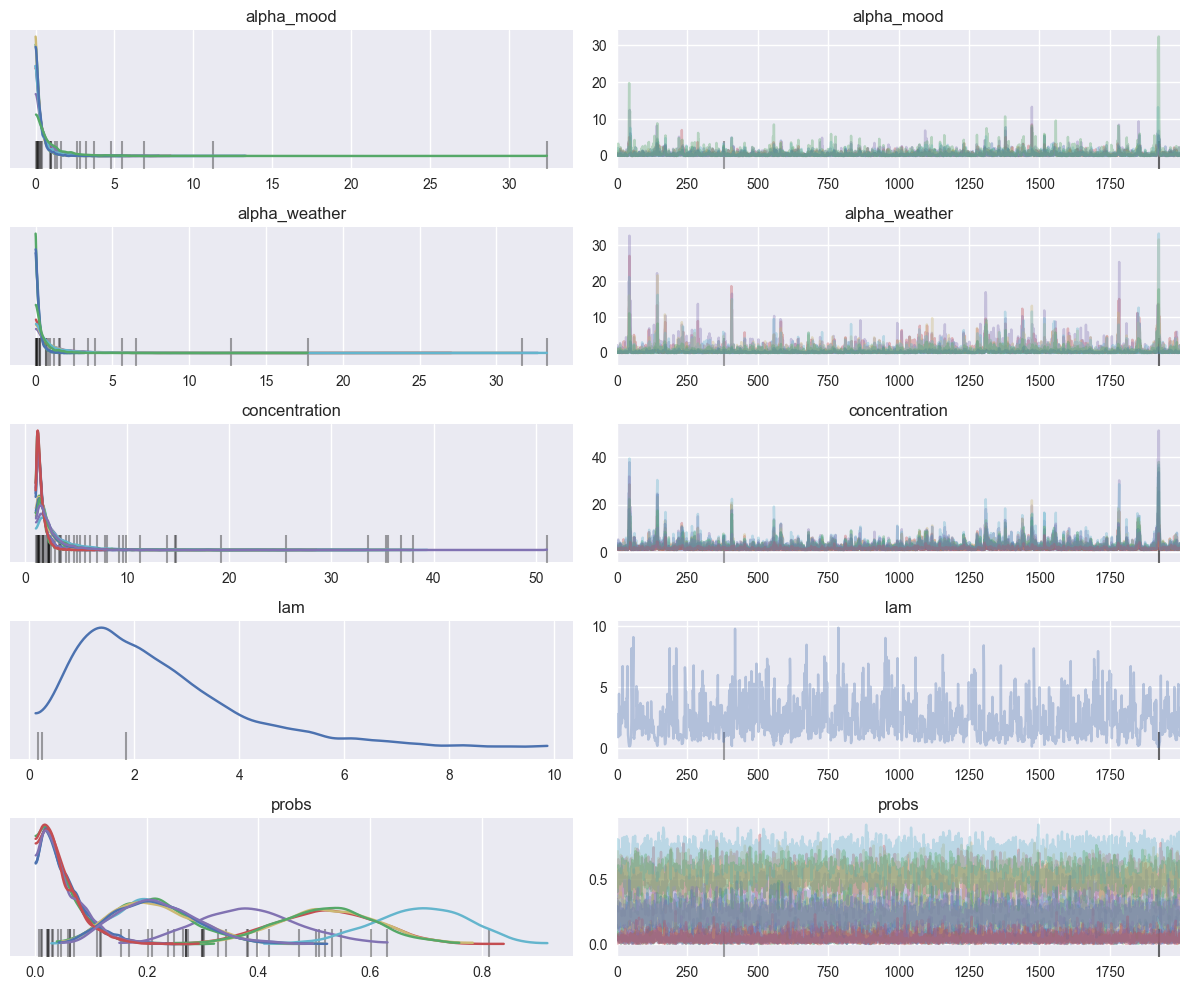

In [53]:
import arviz as az
import matplotlib.pyplot as plt

trace = az.from_numpyro(mcmc)
az.plot_trace(trace)
plt.tight_layout()
plt.show()

In [57]:
predictive = Predictive(model, mcmc.get_samples(), return_sites=['obs', 'concentration'])
pred = predictive(random.PRNGKey(1), mood=mood, weather=weather)
conentration = pred["concentration"] 
print(jnp.mean(conentration, axis=0))

[[1.6909822 1.5411884 2.5469708 3.0709734]
 [2.5857096 2.4291167 1.660421  2.225944 ]
 [1.5619252 1.680453  2.4326367 3.4502525]
 [2.4566524 2.5683815 1.5460871 2.6052232]]


In [50]:
def ctx2idx(mood: str, weather: str) -> int:
    m = 2 if mood == "chill" else 0
    w = 1 if weather == "sunny" else 0
    return m + w
    
def activity_name(activity_array: jnp.ndarray) -> str:
    idx = jnp.argmax(activity_array)
    return ["cycling", "picnic", "climbing", "movie"][idx]


activity_arrays = pred["obs"][:,ctx2idx("active", "rainy"),:]
for i in range(10):    
    print(f"Activity: {activity_name(activity_arrays[i])}", activity_arrays[i])


Activity: movie [0. 0. 0. 1.]
Activity: movie [0. 0. 0. 1.]
Activity: movie [0. 0. 0. 1.]
Activity: movie [0. 0. 0. 1.]
Activity: movie [0. 0. 0. 1.]
Activity: climbing [0. 0. 1. 0.]
Activity: climbing [0. 0. 1. 0.]
Activity: climbing [0. 0. 1. 0.]
Activity: movie [0. 0. 0. 1.]
Activity: climbing [0. 0. 1. 0.]
